#### **Import Libraries**

In [1]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall, compute_f1_score
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, concatenate_datasets


import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from sklearn.model_selection import train_test_split

#### **Parameters**

In [2]:
seed = 1                        # Seed
prompt = True                  # Whether to include a prompt about who is likely to take up the treatment if offered
noise = False                    # Whether covariates can predict the takeup of treatment
sample_size = 500              # Sample Size
val_set_fraction = 0.25         # Fraction of sample used for validation set
data_version = 2                # version of synthetic data         
class_weight_type = 'standard'  
lr = 2e-4                       # Optimizer learning rate
warmup_ratio = 0.25             # Fraction of training epochs used for learning rate warm up
batch_size = 32                 # Number of observations in each mini-batch
epochs = 50                     # Number of training epochs
patience = 30                    
gamma = 0.0


#### **Seed**

In [3]:
np.random.seed(seed)

#### **Set Up Paths**

In [4]:
data_csv = f'./../../../toy-data/exp2/data_{data_version}.csv'

In [5]:
df = pd.read_csv(data_csv)
df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Description
0,8,1,3,1015,8,44,0,The tenant is a 52-year-old individual with se...
1,8,2,2,1118,0,37,0,The tenant is a middle-aged individual in thei...
2,6,0,3,1099,6,28,0,The tenant is a 45-year-old individual who has...
3,2,2,2,1493,0,28,1,The tenant is a creative and ambitious individ...
4,8,2,1,1314,1,38,0,The tenant is a middle-aged individual in thei...


#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_60pt/Newsreader_60pt-Light.ttf


#### **First Stage Function**

In [7]:
conditions_not_covered = [
    "Good Health",
    "Mild Behavioral and Psychological Traits",
    "Temporary Conditions"]

conditions_covered = [
    "Mobility and Physical Disabilities",
    "Chronic and Severe Illnesses",
    "Developmental Disabilities",
    "Severe Cognitive and Learning Disabilities",
    "Psychiatric and Severe Mental Health Disorders"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7):
    return 1*(var5 >= 5) 

In [8]:
import re

def extract_information(text):
    # Define simple search terms
    has_lawyer_access = 'This tenant **has access** to a free lawyer.' in text
    has_voucher = 'housing voucher' in text
    
    # Define conditions
    conditions = conditions = [ "Good Health",
    "Mild Behavioral and Psychological Traits",
    "Temporary Conditions",
    "Mobility and Physical Disabilities",
    "Chronic and Severe Illnesses",
    "Developmental Disabilities",
    "Severe Cognitive and Learning Disabilities",
    "Psychiatric and Severe Mental Health Disorders"
]
    
    # Check for conditions
    condition_status = [condition for condition in conditions if condition.lower() in text.lower()]
    condition_status = f"covered conditions: {', '.join(condition_status)}"
    lawyer_status = "tenant has access to legal representation" if has_lawyer_access else "the right to counsel is not in effect"
    voucher_status = "tenant has a housing voucher" if has_voucher else "tenant does not have a housing voucher"
    result = f"{lawyer_status}, {voucher_status}, {condition_status}"
    return result

#### **Read in Data**

In [9]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n'
string1 = "Note: Some tenants have access to a free lawyer others don't. This tenant **has access** to a free lawyer.\n\n"
string0 = "Note: Some tenants have access to a free lawyer others don't. This tenant **does not have access** to a free lawyer.\n\n"
if prompt:

    context = "Also Note: Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."
else:
    context = ''

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
df = pd.concat([df]*2, ignore_index=True)
sample_size = df.shape[0]
# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values 
midpoint = len(df) // 2 
df['Instrument'] = np.where(df.index < midpoint, 1, 0)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + string1 + 'Description:' + df['Description'].replace("\n", "") + '\n\n' + context,
                             string_b + string0 + 'Description:' + df['Description'].replace("\n", "") + '\n\n'+ context)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + string1 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + string0 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=sample_size)

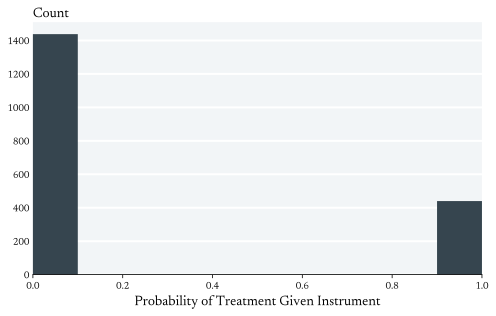

In [10]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

In [11]:
# Building the vocabulary
def build_vocab(sentences):
    vocab = Counter()
    for sentence in sentences:
        for word in sentence.split():
            vocab[word] += 1
    return {word: i for i, (word, _) in enumerate(vocab.items())}

vocab = build_vocab(df.FullDescription.apply(extract_information))
vocab_size = len(vocab)
print(vocab_size)

41


In [12]:
# Encoding sentences as BoW vectors
def encode_sentence(sentence, vocab):
    vector = torch.zeros(len(vocab))
    for word in sentence.split():
        if word in vocab:
            vector[vocab[word]] += 1
    return vector

# Encode all sentences
X = torch.stack([encode_sentence(sentence, vocab) for sentence in df.FullDescription.apply(extract_information)])
y = torch.tensor(df.Treatment, dtype=torch.float32)

In [13]:
class BoWModel(nn.Module):
    def __init__(self, vocab_size):
        super(BoWModel, self).__init__()
        self.fc1 = nn.Linear(vocab_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [14]:
# Model initialization
model = BoWModel(vocab_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
verbose = False

# Training the model
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X).squeeze()
    loss = criterion(outputs, y)
    
    loss.backward()
    optimizer.step()
    
    if ((epoch+1) % 10 == 0) & verbose:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        sns.kdeplot(outputs.detach().numpy(), color='blue', fill=False, bw_adjust=0.25, label='Train')
        plt.show()

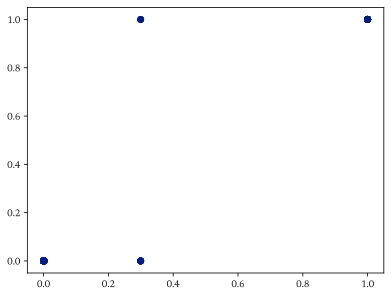

In [15]:
plt.scatter(outputs.detach().numpy() , df.FStage_Value*df.Treatment);

In [16]:
idx = np.abs(outputs.detach().numpy() - df.FStage_Value*df.Treatment) > 0.02
idx.mean()

0.005324813631522897

In [17]:
df[idx][['Description', 'FStage_Value', 'Instrument', 'Treatment']]

,Description,FStage_Value,Instrument,Treatment
28,The tenant is a mid-40s individual who has bee...,0,1,0
368,The tenant is a middle-aged individual in thei...,1,1,1
421,The tenant is a middle-aged individual in thei...,0,1,0
423,The tenant is a 35-year-old individual with si...,1,1,1
523,The tenant is a middle-aged individual in thei...,0,1,0
526,The tenant is a young professional in their la...,0,1,0
601,The tenant is a middle-aged individual in thei...,0,1,0
620,The tenant is a middle-aged individual in thei...,0,1,0
731,The tenant is a hardworking individual in thei...,0,1,0
773,The tenant is a middle-aged individual in thei...,1,1,1


In [18]:
to_markdown(df[idx][['FullDescription', 'FStage_Value', 'Instrument', 'Treatment']]['FullDescription'].values[1])

> Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
> Note: Some tenants have access to a free lawyer others don't. This tenant **has access** to a free lawyer.
> 
> Description:The tenant is a middle-aged individual in their late-40s who is currently late on their rent payment of $1168. They have been living in a large apartment complex for 35 months and have a physical disability that affects their mobility. Despite these challenges, the tenant is an adventurous foodie who loves to explore different cuisines and try new recipes. They have a beloved pet bird that brings them joy in their daily life. The combination of their physical disabilities, financial struggles, and passion for cooking paint a complex picture of this tenant's circumstances.
> 
> Also Note: Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.

In [19]:
sentence = 'housing voucher mobility impairments This tenant **has access** to a free lawyer'
sentence = extract_information(df[idx][['FullDescription', 'FStage_Value', 'Instrument', 'Treatment']]['FullDescription'].values[0])
model(encode_sentence(sentence, vocab))

tensor([0.2997], grad_fn=<SigmoidBackward0>)

In [20]:
sentence

'tenant has access to legal representation, tenant does not have a housing voucher, covered conditions: '